# HW4: Structure-from-motion

In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import hw3

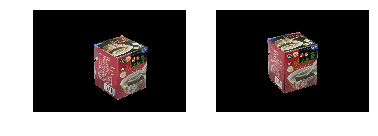

In [49]:
image1 = cv2.imread('./data/Mesona1.JPG')
image2 = cv2.imread('./data/Mesona2.JPG')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(image1), plt.axis('off')
plt.subplot(122), plt.imshow(image2), plt.axis('off')
plt.show()

In [50]:
intrinsic_matrix1 = np.array([[1.4219, 0.005, 0.5092],
                              [0, 1.4219, 0.3802],
                              [0, 0, 0.0010]])
print(intrinsic_matrix1)
print(np.transpose(intrinsic_matrix1))

[[  1.42190000e+00   5.00000000e-03   5.09200000e-01]
 [  0.00000000e+00   1.42190000e+00   3.80200000e-01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e-03]]
[[  1.42190000e+00   0.00000000e+00   0.00000000e+00]
 [  5.00000000e-03   1.42190000e+00   0.00000000e+00]
 [  5.09200000e-01   3.80200000e-01   1.00000000e-03]]


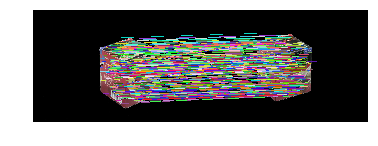

(<matplotlib.image.AxesImage at 0x26b0209bf60>,
 (-0.5, 2399.5, 799.5, -0.5),
 None)

In [51]:
sift = cv2.xfeatures2d.SIFT_create()

(keypt1, desc1) = sift.detectAndCompute(image1, None)
(keypt2, desc2) = sift.detectAndCompute(image2, None)

BF_MACTHEr_DISTANCE = 0.65
matches = hw3.brute_force_matcher(desc1, desc2, BF_MACTHEr_DISTANCE)
matched_pt_order = hw3.sort_matched_points(matches)

matched_feature_image = hw3.show_matched_image(image1, image2, keypt1, keypt2, matched_pt_order)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()

In [52]:
imgpts1, imgpts2 = hw3.get_matched_points(matched_pt_order, keypt1, keypt2)
fundamental_matrix = cv2.findFundamentalMat(imgpts1, imgpts2, cv2.RANSAC, 1., 0.99, None)
print(fundamental_matrix[0])

essential_matrix = (np.transpose(intrinsic_matrix1) * fundamental_matrix * intrinsic_matrix1
print(essential_matrix)

[[  1.30170502e-07  -3.74285972e-07  -1.35177595e-03]
 [ -2.20353024e-06  -6.57283249e-08   2.48823660e-02]
 [  5.31704934e-04  -2.24088850e-02   1.00000000e+00]]


ValueError: operands could not be broadcast together with shapes (3,3) (2,) 